In [1]:
import pyspark
#sc = pyspark.SparkContext('local[*]')

In [2]:
!rm -rf metastore_db/*.lck

from pyspark.sql import SQLContext
sqlc = SQLContext(sc)

### Step 1
- Load the train and test sets
- Check the schema, the variables have their right types?
- If not, how to correctly load the datasets?

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

customSchema = StructType([StructField("PassengerId", IntegerType(), True),
                           StructField("Survived", DoubleType(), True),
                           StructField("Pclass", IntegerType(), True), 
                           StructField("Name", StringType(), True),
                           StructField("Sex", StringType(), True),
                           StructField("Age", DoubleType(), True),
                           StructField("SibSp", IntegerType(), True),
                           StructField("Parch", IntegerType(), True),
                           StructField("Ticket", StringType(), True),
                           StructField("Fare", DoubleType(), True),
                           StructField("Cabin", StringType(), True),
                           StructField("Embarked", StringType(), True)])

customSchema2 = StructType([StructField("PassengerId", IntegerType(), True),
                           StructField("Pclass", IntegerType(), True), 
                           StructField("Name", StringType(), True),
                           StructField("Sex", StringType(), True),
                           StructField("Age", DoubleType(), True),
                           StructField("SibSp", IntegerType(), True),
                           StructField("Parch", IntegerType(), True),
                           StructField("Ticket", StringType(), True),
                           StructField("Fare", DoubleType(), True),
                           StructField("Cabin", StringType(), True),
                           StructField("Embarked", StringType(), True)])

train = sqlc.read.csv("train.csv", header=True, schema=customSchema)
test = sqlc.read.csv("test.csv", header=True, schema=customSchema2)

### Step 2
- Explore the features of your dataset
- You can use DataFrame's ***describe*** method to get summary statistics
    - hint: ***toPandas*** may be useful to ease the manipulation of small dataframes
- Are there any ***NaN*** values in your dataset?
- If so, define value/values to fill these ***NaN*** values
    - hint: ***na*** property of DataFrames provide several methods of handling NA values

In [4]:
# Calculating summary statistics and turning it into Pandas DF
train_desc = train.describe().toPandas().set_index('summary')
train_desc

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
summary,,,,,,,,,,,,
count,891,891,891,891,891,714,891,891,891,891,204,889
mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
min,1,0.0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
max,891,1.0,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


In [5]:
train.stat.corr('Pclass', 'Fare')

-0.5494996199439076

In [6]:
# Computing correlations between Survived and some features
print({col:train.stat.corr('Survived',col) for col in ['Pclass','Age','SibSp','Parch','Fare']})

# Checking which columns have NULL values
print({col:train.where(train[col].isNull()).count() for col in train.columns})

# Taking the mean age from the Pandas DF
ageMean = float(train_desc.loc['mean']['Age'])
print(ageMean)

{'Pclass': -0.3384810359610151, 'Age': 0.010539215871285682, 'SibSp': -0.0353224988857356, 'Parch': 0.08162940708348339, 'Fare': 0.2573065223849626}
{'PassengerId': 0, 'Survived': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 177, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 0, 'Cabin': 687, 'Embarked': 2}
29.69911764705882


In [7]:
train.groupby('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [8]:
# Filling the Age in both train and test datasets
trainFilled = train.na.fill({'Age': ageMean, 'Embarked': 'S'})
testFilled = test.na.fill({'Age': ageMean, 'Embarked': 'S'})

In [9]:
trainFilled.describe().toPandas().set_index('summary')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
summary,,,,,,,,,,,,
count,891,891,891,891,891,891,891,891,891,891,204,891
mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.699117647058763,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,13.002015226002891,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
min,1,0.0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
max,891,1.0,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


### Using Imputer

In [10]:
from pyspark.ml.feature import Imputer
imputer = Imputer().setInputCols(['Age']).setOutputCols(['Age']).setStrategy('median')
age_imputer = imputer.fit(train)

In [11]:
trainFilled = age_imputer.transform(train)
testFilled = age_imputer.transform(test)

In [12]:
trainFilled = trainFilled.na.fill({'Embarked': 'S'})
testFilled = testFilled.na.fill({'Embarked': 'S'})

In [13]:
train.summary().toPandas().set_index('summary')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
summary,,,,,,,,,,,,
count,891,891,891,891,891,714,891,891,891,891,204,889
mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
min,1,0.0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
25%,223,0.0,2,None,None,20.0,0,0,19996.0,7.8958,None,None
50%,446,0.0,3,None,None,28.0,0,0,236171.0,14.4542,None,None
75%,669,1.0,3,None,None,38.0,1,0,347743.0,31.0,None,None
max,891,1.0,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


### Using Pandas UDF to fill values - what is the issue?

In [16]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(train.schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def pandas_fill_age(pdf):
    return pdf.assign(Age=pdf.Age.fillna(pdf.Age.mean()))

train.groupby('Pclass', 'Sex').apply(pandas_fill_age).sort('PassengerId').limit(10).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,None,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,None,S
5,6,0.0,3,"Moran, Mr. James",male,26.507589,0,0,330877,8.4583,None,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,None,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,None,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,None,C


### Using Pandas UDF - doing it better!

In [112]:
from pyspark.sql import functions as F
strat_ages = train.groupby('PClass', 'Sex').agg(F.mean('Age').alias('Age')).toPandas().set_index(['PClass', 'Sex'])

In [113]:
strat_ages

,,Age
PClass,Sex,
2,female,28.722973
3,male,26.507589
1,male,41.281386
3,female,21.750000
1,female,34.611765
2,male,30.740707


In [119]:
import numpy as np
def get_age(row):
    if np.isnan(row.Age):
        return strat_ages.loc[row.Pclass, row.Sex].Age
    else:
        return row.Age

In [121]:
@pandas_udf(train.schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def pandas_fill_age_lookup(pdf):
    return pdf.assign(Age=pdf.apply(get_age, axis=1))

train.groupby('Pclass', 'Sex').apply(pandas_fill_age_lookup).sort('PassengerId').limit(20).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,None,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,None,S
5,6,0.0,3,"Moran, Mr. James",male,26.507589,0,0,330877,8.4583,None,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,None,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,None,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,None,C


### Step 3
- How to handle categorical features?
    - hint: check the Estimators and Transformers
- Assemble all desired features into a Vector using the VectorAssembler Transformer
- Make sure to end up with a DataFrame with two columns: ***Survived*** and ***vFeatures***

In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.util import MLUtils

# Applying Estimators and Transformators
# Here, I actually fitted and transformed them on the training data
# with the purpose of being able to check the intermediate steps

indexer1 = (StringIndexer()
           .setInputCol("Embarked")
           .setOutputCol("nEmbarked")
           .setHandleInvalid('skip'))

indexer1_model = indexer1.fit(trainFilled)
indexed1 = indexer1_model.transform(trainFilled)

In [20]:
indexer1_model.labels

['S', 'C', 'Q']

In [21]:
indexed1.limit(10).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,nEmbarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,0.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,0.0
5,6,0.0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,None,Q,2.0
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.0
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S,0.0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S,0.0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,None,C,1.0


In [22]:
indexer2 = (StringIndexer()
           .setInputCol("Sex")
           .setOutputCol("nSex")
           .setHandleInvalid('skip'))

indexer2_model = indexer2.fit(indexed1)
indexed2 = indexer2_model.transform(indexed1)

In [23]:
indexer2_model.labels

['male', 'female']

In [24]:
indexed2.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,nEmbarked,nSex
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,0.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,0.0,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,1.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,0.0,0.0


In [25]:
encoder1 = OneHotEncoder().setInputCol("nEmbarked").setOutputCol("vEmbarked").setDropLast(False)
encoded1 = encoder1.transform(indexed2)

encoder2 = OneHotEncoder().setInputCol("nSex").setOutputCol("vSex")
encoded2 = encoder2.transform(encoded1)

In [26]:
encoded2.limit(10).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,nEmbarked,nSex,vEmbarked,vSex
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,0.0,0.0,"(1.0, 0.0, 0.0)",(1.0)
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1.0,"(0.0, 1.0, 0.0)",(0.0)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,0.0,1.0,"(1.0, 0.0, 0.0)",(0.0)
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0,1.0,"(1.0, 0.0, 0.0)",(0.0)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,0.0,0.0,"(1.0, 0.0, 0.0)",(1.0)
5,6,0.0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,None,Q,2.0,0.0,"(0.0, 0.0, 1.0)",(1.0)
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.0,0.0,"(1.0, 0.0, 0.0)",(1.0)
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S,0.0,0.0,"(1.0, 0.0, 0.0)",(1.0)
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S,0.0,1.0,"(1.0, 0.0, 0.0)",(0.0)
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,None,C,1.0,1.0,"(0.0, 1.0, 0.0)",(0.0)


In [27]:
# Using a VectorAssembler to put together all feature columns
assembler = VectorAssembler(inputCols=['Pclass',
                                       'Age',
                                       'SibSp',
                                       'Parch',
                                       'Fare',
                                       'vSex',
                                       'vEmbarked'], 
                            outputCol='vFeatures')

assembled = assembler.transform(encoded2)

In [28]:
assembled.select('Sex', 'nSex', 'vSex', 'Embarked', 'nEmbarked', 'vEmbarked').limit(10).toPandas()

,Sex,nSex,vSex,Embarked,nEmbarked,vEmbarked
0,male,0.0,(1.0),S,0.0,"(1.0, 0.0, 0.0)"
1,female,1.0,(0.0),C,1.0,"(0.0, 1.0, 0.0)"
2,female,1.0,(0.0),S,0.0,"(1.0, 0.0, 0.0)"
3,female,1.0,(0.0),S,0.0,"(1.0, 0.0, 0.0)"
4,male,0.0,(1.0),S,0.0,"(1.0, 0.0, 0.0)"
5,male,0.0,(1.0),Q,2.0,"(0.0, 0.0, 1.0)"
6,male,0.0,(1.0),S,0.0,"(1.0, 0.0, 0.0)"
7,male,0.0,(1.0),S,0.0,"(1.0, 0.0, 0.0)"
8,female,1.0,(0.0),S,0.0,"(1.0, 0.0, 0.0)"
9,female,1.0,(0.0),C,1.0,"(0.0, 1.0, 0.0)"


In [29]:
# Keeping only the features and label columns to 
assembled2 = assembled.select("Survived","vFeatures")

In [30]:
assembled2.limit(5).toPandas()

,Survived,vFeatures
0,0.0,"[3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 1.0, 0.0, 0.0]"
1,1.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 0.0, 0.0, 1.0, ..."
2,1.0,"(3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 0.0, 0.0)"
3,1.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 0.0, 1.0, 0.0, 0.0]"
4,0.0,"[3.0, 35.0, 0.0, 0.0, 8.05, 1.0, 1.0, 0.0, 0.0]"


### Step 4
- Apply a normalization Estimator of your choice to the ***features*** vector obtained in Step 3

In [31]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler().setInputCol("vFeatures").setOutputCol("scaledFeat").setWithStd(True).setWithMean(True)
scalerModel = scaler.fit(assembled2)
scaled = scalerModel.transform(assembled2)

In [32]:
scaled.limit(10).toPandas()

,Survived,vFeatures,scaledFeat
0,0.0,"[3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 1.0, 0.0, 0.0]","[0.8269128165243681, -0.5654188991856529, 0.43..."
1,1.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 0.0, 0.0, 1.0, ...","[-1.5652278312782775, 0.6634883904242593, 0.43..."
2,1.0,"(3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 0.0, 0.0)","[0.8269128165243681, -0.2581920767831749, -0.4..."
3,1.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 0.0, 1.0, 0.0, 0.0]","[-1.5652278312782775, 0.43306827362240075, 0.4..."
4,0.0,"[3.0, 35.0, 0.0, 0.0, 8.05, 1.0, 1.0, 0.0, 0.0]","[0.8269128165243681, 0.43306827362240075, -0.4..."
5,0.0,"[3.0, 28.0, 0.0, 0.0, 8.4583, 1.0, 0.0, 0.0, 1.0]","[0.8269128165243681, -0.10457866558193585, -0...."
6,0.0,"[1.0, 54.0, 0.0, 0.0, 51.8625, 1.0, 1.0, 0.0, ...","[-1.5652278312782775, 1.8923956800341715, -0.4..."
7,0.0,"[3.0, 2.0, 3.0, 1.0, 21.075, 1.0, 1.0, 0.0, 0.0]","[0.8269128165243681, -2.1015530111980434, 2.24..."
8,1.0,"[3.0, 27.0, 0.0, 2.0, 11.1333, 0.0, 1.0, 0.0, ...","[0.8269128165243681, -0.18138537118255538, -0...."
9,1.0,"[2.0, 14.0, 1.0, 0.0, 30.0708, 0.0, 0.0, 1.0, ...","[-0.36915750737695474, -1.179872543990609, 0.4..."


### Step 5
- Instead of doing transformations on separate steps, put everything together with a Pipeline

In [33]:
from pyspark.ml.pipeline import Pipeline

pipeline = Pipeline(stages=[indexer1,
                            indexer2,
                            encoder1, 
                            encoder2, 
                            assembler,
                            scaler])

In [34]:
model = pipeline.fit(trainFilled)
scaled = model.transform(trainFilled)

In [35]:
scaled.select('Survived', 'scaledFeat').limit(10).toPandas()

,Survived,scaledFeat
0,0.0,"[0.8269128165243681, -0.5654188991856529, 0.43..."
1,1.0,"[-1.5652278312782775, 0.6634883904242593, 0.43..."
2,1.0,"[0.8269128165243681, -0.2581920767831749, -0.4..."
3,1.0,"[-1.5652278312782775, 0.43306827362240075, 0.4..."
4,0.0,"[0.8269128165243681, 0.43306827362240075, -0.4..."
5,0.0,"[0.8269128165243681, -0.10457866558193585, -0...."
6,0.0,"[-1.5652278312782775, 1.8923956800341715, -0.4..."
7,0.0,"[0.8269128165243681, -2.1015530111980434, 2.24..."
8,1.0,"[0.8269128165243681, -0.18138537118255538, -0...."
9,1.0,"[-0.36915750737695474, -1.179872543990609, 0.4..."


### Step 6
- Train a classifier of your choice (for instance, Random Forest) using your dataset of LabeledPoints
- Make predictions for the training data
- Use the evaluators to find the Area Under ROC and Accuracy of your model
- How is your model performing? Try to tune its parameters

In [36]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel

# Trains a RF classifier and make predictions
rfC = RandomForestClassifier().setLabelCol("Survived") \
                                .setFeaturesCol("scaledFeat") \
                                .setNumTrees(50)

model = rfC.fit(scaled)

predictions1 = model.transform(scaled)

In [37]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression().setLabelCol('Survived').setFeaturesCol('scaledFeat')
lrmodel = lr.fit(scaled)
predictions2 = lrmodel.transform(scaled)

In [38]:
summary = lrmodel.summary
print(summary.accuracy)
print(summary.areaUnderROC)

0.797979797979798
0.8572151386359036


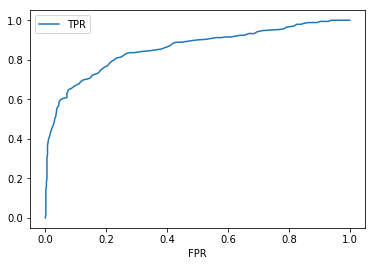

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline
summary.roc.toPandas().plot(x='FPR', y='TPR')

In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Defines an evaluator based on the metric areaUnderROC
evaluator = BinaryClassificationEvaluator().setLabelCol("Survived") \
                            .setRawPredictionCol("rawPrediction") \
                            .setMetricName("areaUnderROC")

ev2 = (MulticlassClassificationEvaluator()
       .setLabelCol('Survived')
       .setPredictionCol('prediction')
       .setMetricName('accuracy'))

In [41]:
# Evaluate the predictions
roc = evaluator.evaluate(predictions1)
print(roc)

acc = ev2.evaluate(predictions1)
print(acc)

0.9043343026661986
0.8507295173961841


In [42]:
# Evaluate the predictions
roc = evaluator.evaluate(predictions2)
print(roc)

acc = ev2.evaluate(predictions2)
print(acc)

0.8571219335527661
0.797979797979798


### Step 7
- Take a look at the test data - use DataFrame's ***createOrReplaceTempView*** method to perform SQL queries over the data
    - hint: check if there are any NULL values in the dataset - if so, handle them
- Apply the transformations to the test data
    - hint: include the model to the pipeline
- Make predictions using the model previously trained and the transformed test data

In [43]:
# Make the test set a "table"
testFilled.createOrReplaceTempView('test')

# Runs a series of SQL queries to get the number of null values in the test set
print({col: sqlc.sql("select * from test where " + col + " is null").count() for col in testFilled.columns})

# So, there is one null Fare, let's check it
sqlc.sql("select * from test where Fare is null").toPandas()

# Since the Fare is highly dependent on the class, it makes more sense to use the average for the given class
# But we need to take the average from the TRAINING set
trainFilled.createOrReplaceTempView('train')
avgFare = sqlc.sql("select mean(Fare) from train where Pclass = 3").take(1)[0][0]
print(avgFare)

# Fill the missing value with the calculated average
testFilled = testFilled.na.fill({'Fare': avgFare})

{'PassengerId': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 0, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 1, 'Cabin': 327, 'Embarked': 0}
13.675550101832997


In [44]:
pipeline = Pipeline(stages=[indexer1,
                            indexer2,
                            encoder1, 
                            encoder2, 
                            assembler,
                            scaler,
                            rfC])

model = pipeline.fit(trainFilled)

In [94]:
predictions = model.transform(testFilled)

### Step 7.1

Performing CrossValidation

In [77]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(rfC.numTrees, [50, 100]) \
    .addGrid(rfC.subsamplingRate, [0.6, 0.8]) \
    .addGrid(rfC.minInstancesPerNode, [1, 3, 5]) \
    .addGrid(rfC.maxDepth, [5, 7, 9]) \
    .build()

In [78]:
paramGrid

[{Param(parent='RandomForestClassifier_4b36a5ddcbcd56fe454c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
  Param(parent='RandomForestClassifier_4b36a5ddcbcd56fe454c', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1,
  Param(parent='RandomForestClassifier_4b36a5ddcbcd56fe454c', name='numTrees', doc='Number of trees to train (>= 1).'): 50,
  Param(parent='RandomForestClassifier_4b36a5ddcbcd56fe454c', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 0.6},
 {Param(parent='RandomForestClassifier_4b36a5ddcbcd56fe454c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 le

In [101]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(trainFilled)

In [102]:
cvModel.avgMetrics

[0.8716947420124843,
 0.8724675157693902,
 0.8750306573880275,
 0.869587035298754,
 0.8685887029331905,
 0.8708660754199604,
 0.8688545985879368,
 0.8702323507607514,
 0.869631360935982,
 0.8686472251497876,
 0.8673685907231756,
 0.8672574394233972,
 0.8653628440028067,
 0.8661673377973321,
 0.8663501766785926,
 0.8689309273413907,
 0.8723186764753494,
 0.8718654360677256,
 0.8682715650198636,
 0.8642556815372708,
 0.865571850578398,
 0.8682767907891495,
 0.8677302406996308,
 0.8703276818389598,
 0.8688560273699623,
 0.8681427964450154,
 0.869538536949886,
 0.8682072788214341,
 0.8703254145303105,
 0.8727059391185275,
 0.8695015391200258,
 0.8694285244939173,
 0.8704721464416199,
 0.866729078384453,
 0.8693285943143501,
 0.870969966542648]

In [103]:
cvModel.bestModel

PipelineModel_465d83c7db6bf378f2a1

In [104]:
cvModel.bestModel.stages

[StringIndexer_4a3691cad59353faa506,
 StringIndexer_48fcb223505f4cb24c71,
 OneHotEncoder_416799e8a11e9329b49b,
 OneHotEncoder_414e8c85e10f38e967ac,
 VectorAssembler_48cfb7ada7857303910a,
 StandardScaler_43c495e097928fb19b34,
 RandomForestClassificationModel (uid=RandomForestClassifier_4b36a5ddcbcd56fe454c) with 50 trees]

In [105]:
best_rfc = cvModel.bestModel.stages[-1]
best_parms = best_rfc.extractParamMap()

In [106]:
{p[0].name: p[1] for p in list(best_parms.items())}

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featureSubsetStrategy': 'auto',
 'featuresCol': 'scaledFeat',
 'impurity': 'gini',
 'labelCol': 'Survived',
 'maxBins': 32,
 'maxDepth': 9,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'numTrees': 50,
 'predictionCol': 'prediction',
 'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'seed': -5387697053847413545,
 'subsamplingRate': 0.6}

In [107]:
cv_predictions = cvModel.transform(testFilled)

### Step 8

- Load the answers for the ***test*** data
- Combine it with your predictions into a single DataFrame
- Use the evaluator you created on ***Step 6***
- What was your score?

In [62]:
answers = sqlc.read.csv('titanic_answers.csv', header=True)
answers = answers.select('PassengerId',F.col('Survived').cast('Double'))

In [95]:
pred_answer = predictions.join(answers, on='PassengerId')

In [96]:
roc = evaluator.evaluate(pred_answer)
print(roc)

0.8172590068159695


In [97]:
acc = ev2.evaluate(pred_answer)
print(acc)

0.7870813397129187


In [108]:
cv_pred_answer = cv_predictions.join(answers, on='PassengerId')

In [109]:
roc = evaluator.evaluate(cv_pred_answer)
print(roc)

0.8195472249269724


In [110]:
acc = ev2.evaluate(cv_pred_answer)
print(acc)

0.7822966507177034
